In [71]:
import os
import sys

sys.path.append('/hpc/compgen/users/mpages/babe/src')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import importlib
import plot
importlib.reload(plot)

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

colorpalettetab10 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
output_dir_plots = '/hpc/compgen/users/mpages/babe/results/benchmark/plots/grid'
output_dir_tables = '/hpc/compgen/users/mpages/babe/results/benchmark/tables/grid'

In [3]:
data_dir = '/hpc/compgen/projects/nanoxog/babe/analysis/mpages/models/grid_analysis/human'

In [4]:
evaluation_dfs = list()
for model_dir in os.listdir(data_dir):
    for eval_file in os.listdir(os.path.join(data_dir, model_dir)):
        if eval_file.endswith('.csv'):
            try:
                df = pd.read_csv(os.path.join(data_dir, model_dir, eval_file), header=0, index_col=False)
                config = model_dir.split('_')
                df['model'] = model_dir
                df['cnn'] = config[0]
                df['encoder'] = config[1]
                df['decoder'] = config[2]
                df['beam'] = int(eval_file.split('_')[1])
                df['beam_threshold'] = float(eval_file.split('_')[2])
                evaluation_dfs.append(df)
            except FileNotFoundError:
                continue
df = pd.concat(evaluation_dfs)
df = df.sort_values('model')
df = df.reset_index()

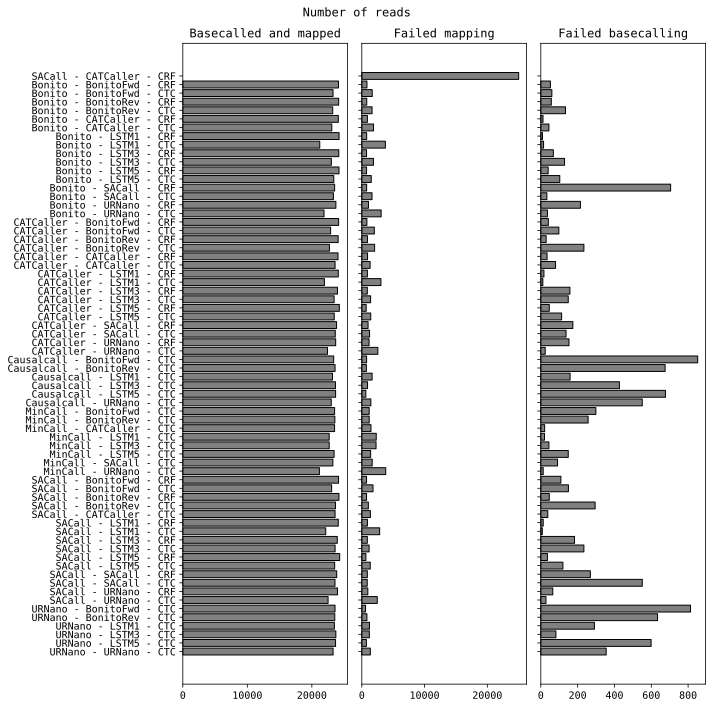

In [11]:
f, plot_df = plot.basecalled_reads_counts(df, figsize=(10, 10))


/hpc/compgen/users/mpages/software/miniconda3/envs/babe/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


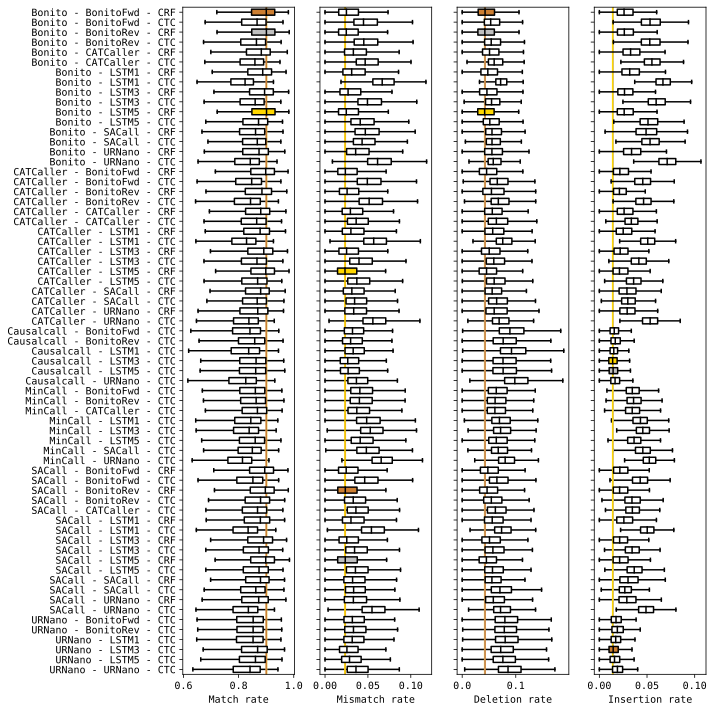

In [78]:
f, plot_df = plot.main_rates(df[df['comment'] == 'pass'], figsize=(10, 10), normalization_column = 'len_reference')

# CRF is better

In [13]:
normalization_column = 'len_reference'
bases = ['A', 'C', 'G', 'T']
match_columns = list()
mismatch_columns = list()
insertion_columns = list()
deletion_columns = list()
for b1 in bases:
    for b2 in bases + ['-']:
        for b3 in bases + ['-']:
            for b4 in bases:
                if b2 == '-' and b3 == '-':
                    continue
                if b2 == b3:
                    match_columns.append(b1 + b2 + '>' + b3 + b4)
                else:
                    if b2 == '-':
                        deletion_columns.append(b1 + b2 + '>' + b3 + b4)
                    elif b3 == '-':
                        insertion_columns.append(b1 + b2 + '>' + b3 + b4)
                    else:
                        mismatch_columns.append(b1 + b2 + '>' + b3 + b4)

df.loc[:, 'matches'] = df[match_columns].sum(axis=1)
df.loc[:, 'mismatches'] = df[mismatch_columns].sum(axis=1)
df.loc[:, 'insertions'] = df[insertion_columns].sum(axis=1)
df.loc[:, 'deletions'] = df[deletion_columns].sum(axis=1)
df.loc[:, 'len_alignment'] = df[['matches', 'mismatches', 'insertions', 'deletions' ]].sum(axis=1)
df.loc[:, 'len_alignment'] += 2

df.loc[:, 'match_rate'] = df['matches']/df[normalization_column]
df.loc[:, 'mismatch_rate'] = df['mismatches']/df[normalization_column]
df.loc[:, 'insertion_rate'] = df['insertions']/df[normalization_column]
df.loc[:, 'deletion_rate'] = df['deletions']/df[normalization_column]

In [15]:
subdf = df[df['comment'] == 'pass']

In [22]:
subdf = subdf.sort_values('model')

In [40]:
from copy import deepcopy
from tqdm import tqdm
l = list()
for modelname in tqdm(np.unique(subdf['model'])):

    if 'ctc' in modelname:
        continue

    ctcmodelname = modelname.replace('crf', 'ctc')
    crfmodelname = deepcopy(modelname)

    for modelname in [ctcmodelname, crfmodelname]:

        model = plot.transform_name(modelname)[:-6]
        st = subdf['model'].searchsorted(modelname, side = 'left')
        nd = subdf['model'].searchsorted(modelname, side = 'rigth')

        if 'ctc' in modelname:
            decoder = 'ctc'
        else:
            decoder = 'crf'

        for metric in ['match_rate', 'mismatch_rate', 'insertion_rate', 'deletion_rate']:
            
            l.append({
                'decoder': decoder,
                'model': model,
                'metric': metric,
                'median': np.median(subdf.iloc[st:nd][metric])
            })

    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 938.76it/s]


In [58]:
plotdf = pd.DataFrame(l)

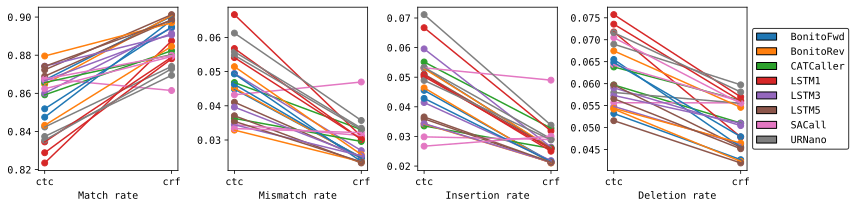

In [76]:
fig, axes = plt.subplots(1, 4, figsize = (12, 3))

c_dict = dict()
i = 0
for ax, metric in zip(axes, ['match_rate', 'mismatch_rate', 'insertion_rate', 'deletion_rate']):

    for model in np.unique(plotdf[plotdf['metric'] == metric]['model']):
        cnnenc = model.strip(' ').split('-')
        cnn = cnnenc[0]
        enc = cnnenc[1]

        k = enc
        if k not in c_dict.keys():
            c_dict[k] = colorpalettetab10[i]
            i += 1

        subplotdf = plotdf[plotdf['metric'] == metric][plotdf[plotdf['metric'] == metric]['model'] == model]
        ax.plot(subplotdf['decoder'], subplotdf['median'], color = c_dict[k])
        ax.scatter(subplotdf['decoder'],subplotdf['median'], color = c_dict[k])

    ax.set_xlabel(plot.metric_name_transformer[metric])

handles, labels = plt.gca().get_legend_handles_labels()

for c, n in zip(colorpalettetab10, list(c_dict.keys())):
    handles.extend([mpatches.Patch(facecolor=c, label=n, edgecolor = 'black', linewidth=1)]) 

plt.legend(handles=handles, edgecolor = 'black', bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.tight_layout()

/hpc/compgen/users/mpages/babe/src/plot.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['phred_mean_correct_error_ratio'] = df['phred_mean_correct'] - df['phred_mean_error']


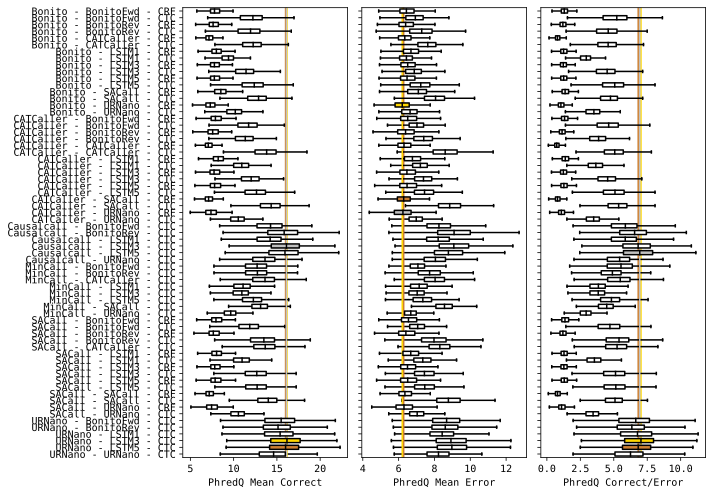

In [66]:
f, plot_df = plot.phredq_distributions(df[df['comment'] == 'pass'], figsize=(10, 7))

/hpc/compgen/users/mpages/babe/src/plot.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_homo_counts'] = df['homo_A_counts'] + df['homo_C_counts'] + df['homo_G_counts'] + df['homo_T_counts']
/hpc/compgen/users/mpages/babe/src/plot.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_homo_errors'] = df['homo_A_errors'] + df['homo_C_errors'] + df['homo_G_errors'] + df['homo_T_errors']
/hpc/compgen/users/mpages/babe/src/plot.py:620: SettingWithCopyWarning: 
A value is trying to be set

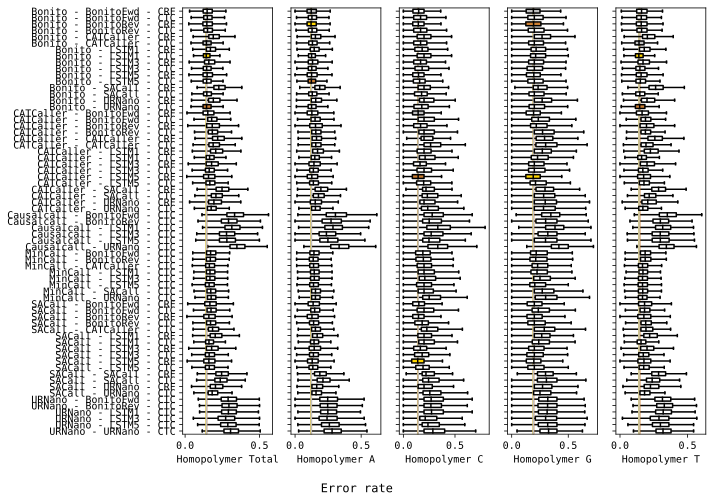

In [67]:
f, plot_df = plot.homopolymer_rates(df[df['comment'] == 'pass'], figsize=(10, 7))

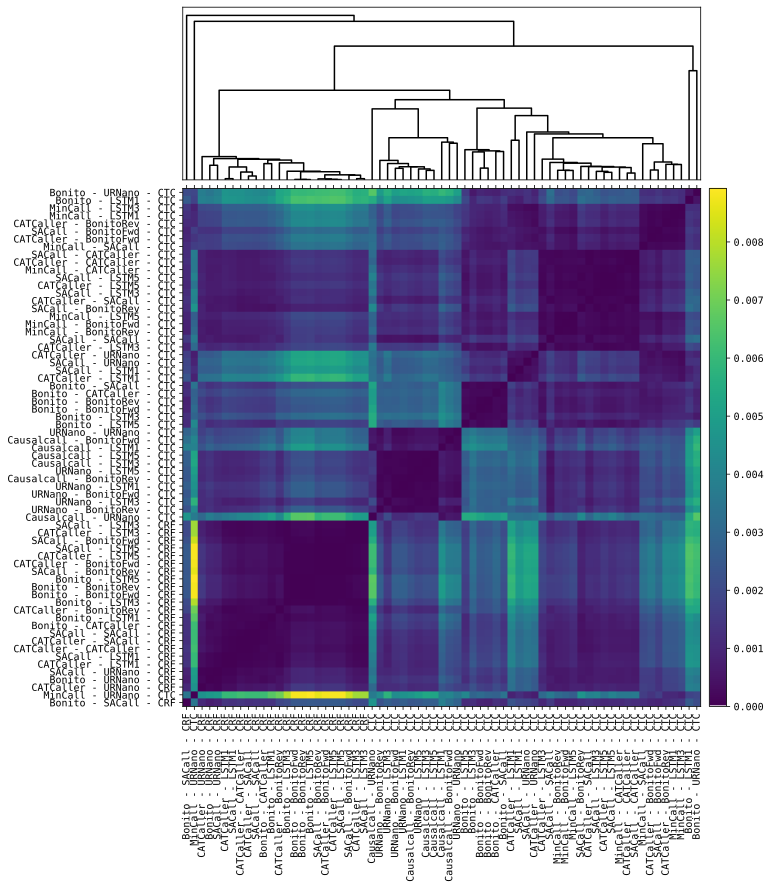

In [77]:
plot.signature_correlation(df[df['comment'] == 'pass'], figsize=(12, 12))